<a href="https://colab.research.google.com/github/PedroAlej0/ISIS1225-Laboratorio-3-prueba/blob/main/Parcial3/Maxwell_Boltzmann_distribution_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [158]:

!pip install emcee
!pip install corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.8 MB/s eta 0:00:00


In [159]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from scipy import integrate
from IPython.display import clear_output
import time
import emcee
import corner
import os

In [161]:
def LogPrior(p):

  if 0 < p < 400 :
    return 0.0
  else:
    return -np.inf

In [2]:

url = "https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/Maxwell.csv"

response = requests.get(url)

In [3]:
contenido = response.text

In [4]:
datos=(np.array(contenido.split("\n")[1:-1])).astype(float)

In [5]:
datos

array([547.26577301, 449.92041803, 773.81438168, ..., 594.98139795,
       376.38861535, 539.81313978])

In [65]:
def likelihood(v,T):
  M = 0.028#densidad por mol

  k_B = 8.31
  m = 0.028 #suponga tenemos un mol
  m = m
  factor = (m / (2 * np.pi * k_B * T)) ** 1.5
  return (factor * 4 * np.pi * v**2 * np.exp(-m * v**2 / (2 * k_B * T)))

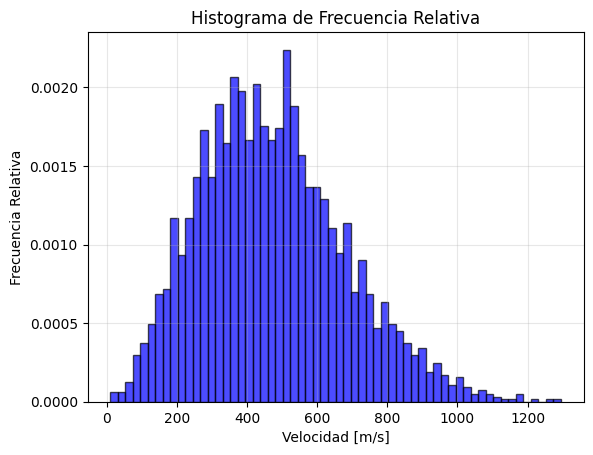

In [101]:
plt.hist(datos, bins=60, density=True, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histograma de Frecuencia Relativa')
plt.xlabel('Velocidad [m/s]')
plt.ylabel('Frecuencia Relativa')


plt.grid(alpha=0.3)
plt.show()


In [7]:
frecuencias, limites_bins = np.histogram(datos, bins=60, density=True)


In [8]:
ancho_bin = limites_bins[1] - limites_bins[0]


puntos_medios = (limites_bins[:-1] + limites_bins[1:]) / 2

promedio_empirico = np.sum(puntos_medios * frecuencias * ancho_bin)

In [9]:
promedio_empirico

472.15396170782543

In [10]:
#comparemos con el promedio de datos natural
np.sum(datos)/len(datos)

472.17578290610606

In [11]:
len(datos)

3000

In [113]:
def joint(T,v):
  z=0
  for i in range(len(v)):
    z+=np.log((likelihood(v[i],T)))
  return -z

In [114]:
from scipy.optimize import minimize
a=minimize(joint,300,args=(datos))
a["x"]

array([297.89577325])

In [100]:
a["x"][0]

297.8957732524406

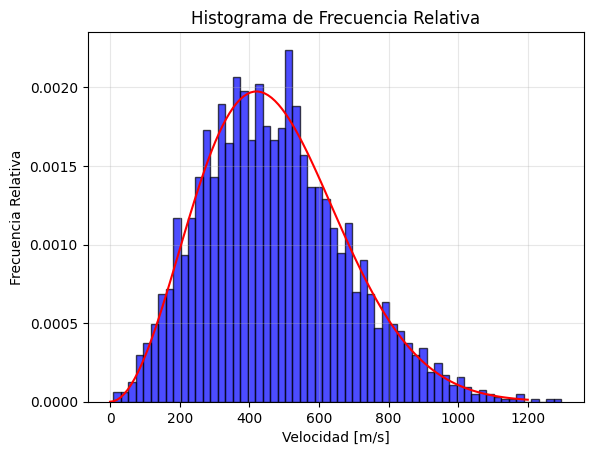

In [102]:
plt.hist(datos, bins=60, density=True, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histograma de Frecuencia Relativa')
plt.xlabel('Velocidad [m/s]')
plt.ylabel('Frecuencia Relativa')
x=np.linspace(0,1200,120)
plt.plot(x,likelihood(x,a["x"][0] ),color='r')

plt.grid(alpha=0.3)
plt.show()


In [121]:
#velocidad más probable:
vp=np.sqrt((2*a["x"][0]*8.314)/0.028)
vp

420.60377170552533

In [125]:
#Calcule la velocidad promedio
vpp=vp*2/np.sqrt(np.pi)
vpp

474.60053359431186

In [127]:
((vpp-promedio_empirico)/promedio_empirico)*100#el error no es de mas del 0.6 % entonces no difiere demasiado del valor empirico

0.51817247866288

In [124]:
#velocidad cuadratica media
vp2=np.sqrt((3*a["x"][0]*8.314)/0.028)
vp2

515.1323122843008

In [162]:
def joint2(T,v):
  z=0
  for i in range(len(v)):
    z+=np.log((likelihood(v[i],T)))
  return z

In [165]:
def LogPosterior(p,x):

  LogP = LogPrior(p)
  if not np.isfinite(LogP):
    return -np.inf
  else:
    return LogP + joint2(p,x)

In [166]:

LogPosterior(200,datos)


-20564.30491842659

In [173]:
n_walkers, n_params = 10,1
p0 = np.zeros((n_walkers, n_params))
p0[:,0] = 200

p0 += np.random.rand(n_walkers, n_params)*10


In [174]:
p0

array([[207.99383181],
       [209.59898308],
       [206.17414029],
       [205.59399823],
       [208.7449704 ],
       [206.60135513],
       [209.34597523],
       [209.23848993],
       [204.11294131],
       [209.95421323]])

In [196]:

sampler = emcee.EnsembleSampler(n_walkers, n_params, LogPosterior, args=(datos,))
pos,prob,state = sampler.run_mcmc(p0,10000,progress=True)

100%|██████████| 10000/10000 [1:32:57<00:00,  1.79it/s]


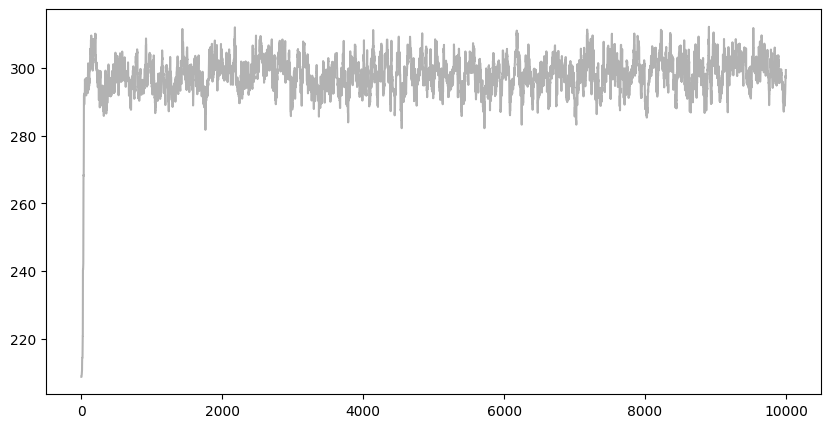

In [198]:
fig, axes = plt.subplots(1, figsize=(10,5), sharex=True)

samples = sampler.get_chain()
labels = ["temperatura"]

ax = axes
ax.plot(samples[:, 0], "k", alpha=0.3)


In [199]:

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)
truths

array([298.00046244])

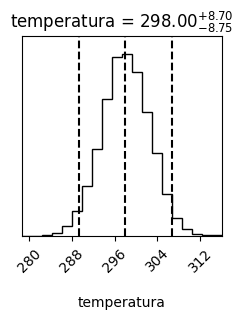

In [200]:
figure = corner.corner(flat_samples, labels=labels, quantiles=[0.025, 0.5, 0.975], show_titles=True)


In [201]:

upperlimits = np.percentile(flat_samples, [0,95], axis=0)
upperlimits


array([[278.60140595],
       [305.27477387]])

In [202]:
error_estandar = np.std(flat_samples)
print(f"Error estándar de la estimación: {error_estandar:.4f}")

Error estándar de la estimación: 4.4649


In [203]:
#empieza a descartar desde:
upperlimits[1]

array([305.27477387])